In [2]:
#all of the setup from the intro.ipynb + more
#remember to run this cell every time you start a new session

from snowshovel.io import read_single_alert, parse_alerts
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline
pd.set_option('display.precision', 5)
# Set this to the directory containing the unzipped avro alerts
data_dir = Path("C:/Users/natha/Downloads/ztf_public_20230609/")

# for showing more decimals if needed
#pd.set_option('display.float_format', '{:.100f}'.format)

In [2]:
#don't adjust this cell
#this takes the longest actually
pd.set_option('display.max_columns', None)
# Set the number of alerts to read (total num is 71708 oh god)
n_to_read = 71708
alerts_df = parse_alerts(data_dir=data_dir, n_to_read=n_to_read)

#(to print it if needed)
#alerts_df

100%|████████████████████████████████████████████████████████████████████████████| 71708/71708 [58:27<00:00, 20.44it/s]


In [3]:
#adjust
useful_columns = [
    "isdiffpos", # Is the detection postive (more flux in science image than reference), or negative (less flux)?
    "ra", # What is the sky position in Right Ascension?
    "dec", # What is the sky position in Declination?
    "magpsf", # What is the magnitude (brightness) of the detection?
    "sigmapsf", # What is the uncertainty on the magnitude?
    "distnr", # How close is the detection to a known source in the reference image?
    "ndethist", # How many times has this object been detected?
]

slim_alerts_df = alerts_df[useful_columns]
#slim_alerts_df

# Bad subtractions are often not repeated
# Let's restrict ourselves to sources which are detected at least twice
mask = slim_alerts_df["ndethist"] > 1
slim_alerts_df = slim_alerts_df[mask].reset_index()
print(f"There are {len(slim_alerts_df)} alerts passing our cut")
slim_alerts_df

There are 42178 alerts passing our cut


,index,isdiffpos,ra,dec,magpsf,sigmapsf,distnr,ndethist
0,0,f,230.91488,-19.23859,17.37607,0.04735,0.16106,620
1,1,f,230.63009,-19.27357,17.23907,0.07838,0.17330,639
2,2,f,231.01415,-19.28220,18.31207,0.06123,0.13447,611
3,3,f,230.90993,-19.48553,18.98307,0.08573,0.42402,721
4,4,f,230.43507,-19.49976,20.10807,0.16492,0.14527,65
...,...,...,...,...,...,...,...,...
42173,71700,t,305.73211,35.63610,16.10253,0.01988,0.62694,898
42174,71701,t,305.73216,35.63609,16.15922,0.08089,0.69454,895
42175,71702,t,305.81875,35.67036,15.61722,0.08950,0.77180,1336
42176,71705,t,305.89926,35.57294,16.47922,0.07272,0.31903,942


In [4]:
#don't adjust
#skiprows because of how the data is given
#total is 432237
#, (10001, 432237) for limiting range to 10000 if needed
skip_ranges = [(0, 8)]
skip_rows = [i for start, end in skip_ranges for i in range(start, end)]
variable_star = pd.read_csv('results6_22_18_27_3827.csv', skiprows=skip_rows)
variable_star

,# vivaID,ra,dec,aVar,bestPeriod
0,515403326727,270.43506,-19.51723,0.13434,0.39252
1,515403270290,270.36061,-19.59807,0.58929,0.03669
2,515403212626,270.68938,-19.90698,0.47464,0.81980
3,515403187805,270.81500,-20.02975,0.55140,0.03760
4,515403141120,270.27365,-19.84197,0.30284,0.84415
...,...,...,...,...,...
432231,515937080067,193.94203,-64.64124,0.36487,0.42431
432232,515937099278,193.99323,-64.27704,0.29054,0.38401
432233,515937113364,194.03036,-64.33027,0.30155,0.03560
432234,515937123034,194.08149,-64.44958,0.42763,8.32291


In [59]:
#merely testing
def make_bins(n_bins):
    decs = np.linspace(-90., 90., n_bins+1)
    for i, lower_dec in enumerate(decs[:-1]):
        upper_dec = decs[i+1]
        print(i, lower_dec, upper_dec)
make_bins(18)

0 -90.0 -80.0
1 -80.0 -70.0
2 -70.0 -60.0
3 -60.0 -50.0
4 -50.0 -40.0
5 -40.0 -30.0
6 -30.0 -20.0
7 -20.0 -10.0
8 -10.0 0.0
9 0.0 10.0
10 10.0 20.0
11 20.0 30.0
12 30.0 40.0
13 40.0 50.0
14 50.0 60.0
15 60.0 70.0
16 70.0 80.0
17 80.0 90.0


In [31]:
# don't touch unless making new bins of different ranges
# define the columns of the original dataframe (slim_alerts_df) to be used in the shortened ones
columns = ["isdiffpos", "ra", "dec", "magpsf", "sigmapsf", "distnr", "ndethist"]

# define the bins for the "dec" column

#the bin_num, range of 1, and -1 in the code works but is bad coding practice; adjust later
bin_num = 37
dec_bins = np.linspace(-90., 90., bin_num)  # 36 bins (1 less than bin_num); each bin with range of 5 degrees

# create a dictionary to store the dataframes for each set, columns in dataframe based on what was defined earlier
slim_sets = {f'slim_set{i}': pd.DataFrame(columns=columns) for i in range(1, bin_num)}

# total number of rows in slim_alerts_df for tqdm
total_rows = len(slim_alerts_df)

# iterate over each row in "slim_alerts_df"
for _, row in tqdm(slim_alerts_df.iterrows(), total=total_rows, desc='making new dataframes for slim_alerts_df'):
    # get the value of the "dec" column on the corresponding row
    dec_value = row["dec"]
    
    # find the bin index where the dec_value falls into
    bin_index = np.digitize(dec_value, dec_bins) - 1
    
    # add the row to the respective set dataframe
    slim_sets[f'slim_set{bin_index}'].loc[len(slim_sets[f'slim_set{bin_index}'])] = row

# now, the "slim_sets" dictionary will contain the filtered dataframes for each set.

# printing to see
for set_name, set_df in slim_sets.items():
    print(f"Set Name: {set_name}")
    print(set_df)
    print()
    
# other dataframe    
# define the columns of the original dataframe (variable_star) to be used in the shortened ones
columns = ["# vivaID","ra","dec","aVar","bestPeriod"]

dec_bins = np.linspace(-90., 90., bin_num) 

# create a dictionary to store the dataframes for each set
var_star_sets = {f'var_star_set{i}': pd.DataFrame(columns=columns) for i in range(1, bin_num)}
# total number of rows in slim_alerts_df
total_rows = len(variable_star)

# iterate over each row in "variable_star"
for _, row in tqdm(variable_star.iterrows(), total=total_rows, desc='Processing variable_star rows'):
    dec_value = row["dec"]
    
    bin_index = np.digitize(dec_value, dec_bins) - 1

    var_star_sets[f'var_star_set{bin_index}'].loc[len(var_star_sets[f'var_star_set{bin_index}'])] = row

for set_name, set_df in var_star_sets.items():
    print(f"Set Name: {set_name}")
    print(set_df)
    print()

Processing slim_alerts_df rows: 100%|███████████████████████████████████████████| 42178/42178 [00:58<00:00, 727.09it/s]


Set Name: slim_set1
Empty DataFrame
Columns: [isdiffpos, ra, dec, magpsf, sigmapsf, distnr, ndethist]
Index: []

Set Name: slim_set2
Empty DataFrame
Columns: [isdiffpos, ra, dec, magpsf, sigmapsf, distnr, ndethist]
Index: []

Set Name: slim_set3
Empty DataFrame
Columns: [isdiffpos, ra, dec, magpsf, sigmapsf, distnr, ndethist]
Index: []

Set Name: slim_set4
Empty DataFrame
Columns: [isdiffpos, ra, dec, magpsf, sigmapsf, distnr, ndethist]
Index: []

Set Name: slim_set5
Empty DataFrame
Columns: [isdiffpos, ra, dec, magpsf, sigmapsf, distnr, ndethist]
Index: []

Set Name: slim_set6
Empty DataFrame
Columns: [isdiffpos, ra, dec, magpsf, sigmapsf, distnr, ndethist]
Index: []

Set Name: slim_set7
Empty DataFrame
Columns: [isdiffpos, ra, dec, magpsf, sigmapsf, distnr, ndethist]
Index: []

Set Name: slim_set8
Empty DataFrame
Columns: [isdiffpos, ra, dec, magpsf, sigmapsf, distnr, ndethist]
Index: []

Set Name: slim_set9
Empty DataFrame
Columns: [isdiffpos, ra, dec, magpsf, sigmapsf, distnr, ndet

Processing variable_star rows: 100%|██████████████████████████████████████████| 432236/432236 [09:05<00:00, 792.41it/s]

Set Name: var_star_set1
Empty DataFrame
Columns: [# vivaID, ra, dec, aVar, bestPeriod]
Index: []

Set Name: var_star_set2
Empty DataFrame
Columns: [# vivaID, ra, dec, aVar, bestPeriod]
Index: []

Set Name: var_star_set3
Empty DataFrame
Columns: [# vivaID, ra, dec, aVar, bestPeriod]
Index: []

Set Name: var_star_set4
       # vivaID         ra       dec     aVar  bestPeriod
0   5.15936e+11  191.68773 -65.01010  0.39028     0.04523
1   5.15935e+11  195.43457 -65.00406  0.16259     2.61416
2   5.15936e+11  190.72193 -65.00429  0.37773     0.06587
3   5.15937e+11  192.84108 -65.03618  0.39342    10.14998
4   5.15937e+11  193.25003 -65.00868  0.49779     0.27047
5   5.15936e+11  190.66214 -65.03791  0.36886     0.05641
6   5.15937e+11  193.07849 -65.01388  0.37238     0.14422
7   5.15935e+11  195.42584 -65.07684  0.35140     0.33178
8   5.15935e+11  195.42859 -65.07964  0.12976     4.72339
9   5.15936e+11  191.51782 -65.03008  0.46414     0.14548
10  5.15936e+11  191.51382 -65.08000  0.5098

In [22]:
# meant to check after adding the "Coordinate" column, probably no longer needed really
# useful for more easily comparing and seeing which data sets actually pair; above cell look for variable star set (number)
# this cell look for slim set (number)

for set_name, set_df in slim_sets.items():
    print(f"Set Name: {set_name}")
    print(set_df)
    print()
for set_name, set_df in var_star_sets.items():
    print(f"Set Name: {set_name}")
    print(set_df)
    print()

Set Name: slim_set1
Empty DataFrame
Columns: [isdiffpos, ra, dec, magpsf, sigmapsf, distnr, ndethist, Coordinate]
Index: []

Set Name: slim_set2
Empty DataFrame
Columns: [isdiffpos, ra, dec, magpsf, sigmapsf, distnr, ndethist, Coordinate]
Index: []

Set Name: slim_set3
Empty DataFrame
Columns: [isdiffpos, ra, dec, magpsf, sigmapsf, distnr, ndethist, Coordinate]
Index: []

Set Name: slim_set4
Empty DataFrame
Columns: [isdiffpos, ra, dec, magpsf, sigmapsf, distnr, ndethist, Coordinate]
Index: []

Set Name: slim_set5
Empty DataFrame
Columns: [isdiffpos, ra, dec, magpsf, sigmapsf, distnr, ndethist, Coordinate]
Index: []

Set Name: slim_set6
Empty DataFrame
Columns: [isdiffpos, ra, dec, magpsf, sigmapsf, distnr, ndethist, Coordinate]
Index: []

Set Name: slim_set7
Empty DataFrame
Columns: [isdiffpos, ra, dec, magpsf, sigmapsf, distnr, ndethist, Coordinate]
Index: []

Set Name: slim_set8
Empty DataFrame
Columns: [isdiffpos, ra, dec, magpsf, sigmapsf, distnr, ndethist, Coordinate]
Index: []



       # vivaID         ra       dec     aVar  bestPeriod  \
0   5.15936e+11  191.68773 -65.01010  0.39028     0.04523   
1   5.15935e+11  195.43457 -65.00406  0.16259     2.61416   
2   5.15936e+11  190.72193 -65.00429  0.37773     0.06587   
3   5.15937e+11  192.84108 -65.03618  0.39342    10.14998   
4   5.15937e+11  193.25003 -65.00868  0.49779     0.27047   
5   5.15936e+11  190.66214 -65.03791  0.36886     0.05641   
6   5.15937e+11  193.07849 -65.01388  0.37238     0.14422   
7   5.15935e+11  195.42584 -65.07684  0.35140     0.33178   
8   5.15935e+11  195.42859 -65.07964  0.12976     4.72339   
9   5.15936e+11  191.51782 -65.03008  0.46414     0.14548   
10  5.15936e+11  191.51382 -65.08000  0.50985     0.05313   
11  5.15936e+11  191.56332 -65.01186  0.89132     0.33307   
12  5.15934e+11  194.27584 -65.01283  0.20040     4.94568   
13  5.15937e+11  194.07582 -65.00819  0.31071     1.68733   
14  5.15935e+11  196.29254 -65.05518  0.36140     0.73779   
15  5.15937e+11  193.116

In [58]:
# loop through each set and save it as a CSV file in the directory for easy access
for set_name, slim_set in slim_sets.items():
    filename = f"{set_name}.csv"  # Name the CSV file based on the set_name
    slim_set.to_csv(filename, index=False)  # Save the DataFrame as CSV without the index column
for set_name, var_star_set in var_star_sets.items():
    filename = f"{set_name}.csv"  # Name the CSV file based on the set_name
    var_star_set.to_csv(filename, index=False)  # Save the DataFrame as CSV without the index column

In [5]:
# read all of the new saved csv files, putting it back into dictionaries since that is what I used earlier 
# (so I don't have to adjust the later code)

slim_sets = {}
var_star_sets = {}
set_num = 1
total_set_num = 36
while set_amount <= total_set_num:
    slim_filename = f"slim_set{set_num}.csv"
    slim_sets[f'slim_set{set_num}'] = pd.read_csv(slim_filename)
    
    var_filename = f"var_star_set{set_num}.csv"
    var_star_sets[f'var_star_set{set_num}'] = pd.read_csv(var_filename)
    
    set_amount += 1

In [21]:
# have to do this again after reading the bin/set files, probably due the "Coordinate" column not being saved as the 
# proper data type; it probably made it into a string/object instead of what it is supposed to be 

# loop through each slim_set, create a coordinate and put value into new "Coordinate" column (for comparisons later)
for set_name, slim_set in tqdm(slim_sets.items(), desc='Processing slim_sets'):
    # update the 'Coordinate' column for the current slim_set
    slim_set["Coordinate"] = SkyCoord(slim_set["ra"], slim_set["dec"], frame='icrs', unit='deg')

# do the same for var_star_set
for set_name, var_star_set in tqdm(var_star_sets.items(), desc='Processing var_star_set'):
    # Update the 'Coordinate' column for the current var_star_set
    var_star_set["Coordinate"] = SkyCoord(var_star_set["ra"], var_star_set["dec"], frame='icrs', unit='deg')

Processing var_star_set: 100%|█████████████████████████████████████████████████████████| 36/36 [01:08<00:00,  1.91s/it]


In [51]:
#new columns to replace what we have (keep shortest distance for the threshold within 2 arcseconds)
#candid from ztf (not hard)
#find objectId
    #github snowshovel io.py return next(freader)['candidate']
    #get it for objectId, add to candidate, and return as one
#vivaID from catalogue (not hard)

# create a list to store the results
results = []

# the set that is being compared
set_num = 12

# get the total number of iterations for tqdm to predict time
total_iterations = len(slim_sets[f'slim_set{set_num}'])

# define the threshold value for dec in arc seconds; masking parts of the set for optimization 
# if too low the code breaks due to comparing something to nothing in the filtered set; might have to change for each pair
# probably a good thing. if code doesn't break that means accuracy isn't lost. if it breaks, accuracy would be lost
cut_threshold = 10
#2 days to 5 min, why did i not think of this sooner

#current thresholds: set 14 (>30 arcseconds so far), set 13 (10 arcseconds), set 12 (10 arcseconds), set 11 (10 arcseconds)

# use tqdm to track progress
# iterating through each data point in the 'coordinate' column for slim_set{set_num}
for slim_index, slim_row in tqdm(slim_sets[f'slim_set{set_num}'].iterrows(), total=total_iterations, desc='Processing coordinates'):
    slim_coord = slim_row['Coordinate']
    
    # creating a list to store the distances for the current slim_set9 coordinate
    # will be used to determine the shortest distance
    distances = []
    # creating a list to store the corresponding indexes in variable_star
    # so we know which data point the shortest distance refers to
    var_star_indexes = []
    
    # filter var_star_set{set_num} based on declination; ± the threshold (inclusive)
    var_star_set_filtered = var_star_sets[f'var_star_set{set_num}'][
        (var_star_sets[f'var_star_set{set_num}']['dec'] >= slim_coord.dec - Angle(cut_threshold, unit='arcsec')) &
        (var_star_sets[f'var_star_set{set_num}']['dec'] <= slim_coord.dec + Angle(cut_threshold, unit='arcsec'))
    ]
    
    # iterate through each data point in the 'coordinate' column in the filtered var_star_set
    for var_index, var_row in var_star_set_filtered.iterrows():
        var_coord = var_row['Coordinate']
        
        # calculate the distance between the two coordinates, record information in the two lists
        dist = slim_coord.separation(var_coord)
        distances.append(dist)
        var_star_indexes.append(var_index)
    
    # find the smallest distance in the list and its corresponding index in variable_star
    smallest_dist = min(distances)
    var_star_index = var_star_indexes[distances.index(smallest_dist)]
    
    # get the coordinates corresponding to the found indexes
    slim_coord_result = slim_sets[f'slim_set{set_num}'].loc[slim_index, "Coordinate"]
    var_coord_result = var_star_sets[f'var_star_set{set_num}'].loc[var_star_index, "Coordinate"]
    
    # append the results to the "results" list
    results.append({
        'slim_alerts_index': slim_index,
        'slim_coord': slim_coord_result, 
        'var_star_index': var_star_index,
        'var_coord': var_coord_result,
        'smallest_dist': smallest_dist
    })

# create the smallest_distances dataset from the "results" list
smallest_distances = pd.DataFrame(results)

print(smallest_distances)

Processing coordinates: 100%|██████████████████████████████████████████████████████| 2123/2123 [03:09<00:00, 11.22it/s]


      slim_alerts_index                                         slim_coord  \
0                     0  <SkyCoord (ICRS): (ra, dec) in deg\n    (232.0...   
1                     1  <SkyCoord (ICRS): (ra, dec) in deg\n    (231.5...   
2                     2  <SkyCoord (ICRS): (ra, dec) in deg\n    (231.6...   
3                     3  <SkyCoord (ICRS): (ra, dec) in deg\n    (231.2...   
4                     4  <SkyCoord (ICRS): (ra, dec) in deg\n    (232.1...   
...                 ...                                                ...   
2118               2118  <SkyCoord (ICRS): (ra, dec) in deg\n    (275.9...   
2119               2119  <SkyCoord (ICRS): (ra, dec) in deg\n    (275.9...   
2120               2120  <SkyCoord (ICRS): (ra, dec) in deg\n    (276.1...   
2121               2121  <SkyCoord (ICRS): (ra, dec) in deg\n    (276.4...   
2122               2122  <SkyCoord (ICRS): (ra, dec) in deg\n    (276.0...   

      var_star_index                                          v

In [52]:
# define the angle and threshold; the angle is a string and must be converted into an angle
angle_str = "00d00m02s"
threshold = Angle(angle_str)

# Extract the numerical value in degrees from the 'smallest_dist' column
degrees_values = smallest_distances['smallest_dist'].apply(lambda x: x.to_value('deg'))

# Compare the numerical values with the threshold value
filtered_distances = smallest_distances[degrees_values < threshold.to_value('deg')]

print(filtered_distances)
#set 13 returned 132 results 
#set 12 returned 160 results

      slim_alerts_index                                         slim_coord  \
1011               1011  <SkyCoord (ICRS): (ra, dec) in deg\n    (280.2...   
1016               1016  <SkyCoord (ICRS): (ra, dec) in deg\n    (280.7...   
1018               1018  <SkyCoord (ICRS): (ra, dec) in deg\n    (280.1...   
1019               1019  <SkyCoord (ICRS): (ra, dec) in deg\n    (280.3...   
1023               1023  <SkyCoord (ICRS): (ra, dec) in deg\n    (280.6...   
...                 ...                                                ...   
2085               2085  <SkyCoord (ICRS): (ra, dec) in deg\n    (276.0...   
2104               2104  <SkyCoord (ICRS): (ra, dec) in deg\n    (276.2...   
2105               2105  <SkyCoord (ICRS): (ra, dec) in deg\n    (276.4...   
2106               2106  <SkyCoord (ICRS): (ra, dec) in deg\n    (276.5...   
2118               2118  <SkyCoord (ICRS): (ra, dec) in deg\n    (275.9...   

      var_star_index                                          v

(array([1257.,   18.,    0.,   11.,   68.,  176.,  233.,  184.,  129.,
          47.]),
 array([1.13499723e-06, 3.23118235e+00, 6.46236357e+00, 9.69354478e+00,
        1.29247260e+01, 1.61559072e+01, 1.93870884e+01, 2.26182696e+01,
        2.58494509e+01, 2.90806321e+01, 3.23118133e+01]),
 <BarContainer object of 10 artists>)

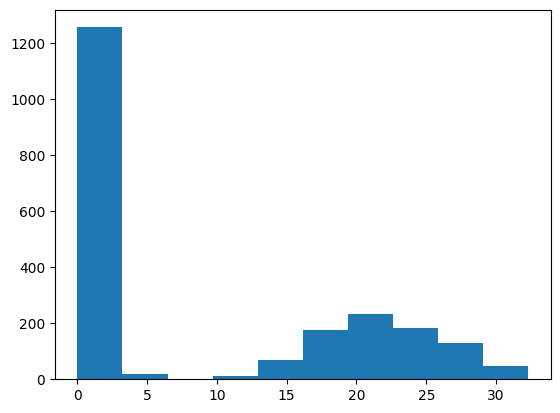

In [45]:
#diagram of distance ranges (not necessary)
plt.hist(degrees_values)

In [49]:
#saving results 
name = f"smallestdistset{set_num}.csv"
smallest_distances.to_csv(name, index=False)

In [148]:
#when I was checking things
"""
#time to debug
lowest_dec = slim_sets['slim_set14']["dec"].min()
print(lowest_dec, "l slimset dec")
highest_dec = slim_sets['slim_set14']["dec"].max()
print(highest_dec, "h slimset dec")

lowest_dec = var_star_sets['var_star_set14']["dec"].min()
print(lowest_dec, "l varset dec")
highest_dec = var_star_sets['var_star_set14']["dec"].max()
print(highest_dec, "h varset dec")

print() 

lowest_dec = slim_sets['slim_set14']["ra"].min()
print(lowest_dec, "l slimset ra")
highest_dec = slim_sets['slim_set14']["ra"].max()
print(highest_dec, "h slimset ra")
lowest_dec = var_star_sets['var_star_set14']["ra"].min()
print(lowest_dec, "l varset ra")
highest_dec = var_star_sets['var_star_set14']["ra"].max()
print(highest_dec, "h varset ra")

# Convert the "dec" and "ra" columns to numeric data types
slim_sets['slim_set14']['dec'] = pd.to_numeric(slim_sets['slim_set14']['dec'])
slim_sets['slim_set14']['ra'] = pd.to_numeric(slim_sets['slim_set14']['ra'])

var_star_sets['var_star_set14']['dec'] = pd.to_numeric(var_star_sets['var_star_set14']['dec'])
var_star_sets['var_star_set14']['ra'] = pd.to_numeric(var_star_sets['var_star_set14']['ra'])

# Find the index of the minimum value in the "dec" column for slim_set14
min_dec_index_slim = slim_sets['slim_set14']["dec"].idxmin()
print(f"Index of the minimum dec value in slim_set14: {min_dec_index_slim}")

# Find the index of the maximum value in the "dec" column for slim_set14
max_dec_index_slim = slim_sets['slim_set14']["dec"].idxmax()
print(f"Index of the maximum dec value in slim_set14: {max_dec_index_slim}")

# Find the index of the minimum value in the "dec" column for var_star_set14
min_dec_index_var = var_star_sets['var_star_set14']["dec"].idxmin()
print(f"Index of the minimum dec value in var_star_set14: {min_dec_index_var}")

# Find the index of the maximum value in the "dec" column for var_star_set14
max_dec_index_var = var_star_sets['var_star_set14']["dec"].idxmax()
print(f"Index of the maximum dec value in var_star_set14: {max_dec_index_var}")

print()

# Find the index of the minimum value in the "ra" column for slim_set14
min_ra_index_slim = slim_sets['slim_set14']["ra"].idxmin()
print(f"Index of the minimum ra value in slim_set14: {min_ra_index_slim}")

# Find the index of the maximum value in the "ra" column for slim_set14
max_ra_index_slim = slim_sets['slim_set14']["ra"].idxmax()
print(f"Index of the maximum ra value in slim_set14: {max_ra_index_slim}")

# Find the index of the minimum value in the "ra" column for var_star_set14
min_ra_index_var = var_star_sets['var_star_set14']["ra"].idxmin()
print(f"Index of the minimum ra value in var_star_set14: {min_ra_index_var}")

# Find the index of the maximum value in the "ra" column for var_star_set14
max_ra_index_var = var_star_sets['var_star_set14']["ra"].idxmax()
print(f"Index of the maximum ra value in var_star_set14: {max_ra_index_var}")


print(smallest_distances.loc[0,"slim_coord"], smallest_distances.loc[0,"var_coord"])
print(smallest_distances.loc[1985,"slim_coord"], smallest_distances.loc[1985,"var_coord"])
#print(smallest_distances["var_star_index"].head(50))
#print(smallest_distances["slim_coord"].head(100))
#print(smallest_distances["var_coord"].head(100))

slim_test = slim_sets['slim_set14'].loc[1,'Coordinate']
var_test = var_star_sets['var_star_set14'].loc[1,'Coordinate']
print(slim_test.separation(var_test))
"""

unique_count = smallest_distances['var_star_index'].nunique()

print(f"The number of unique values in the 'column_name' column of slim_set13 is: {unique_count}")

Index of the minimum dec value in slim_set14: 260
Index of the maximum dec value in slim_set14: 1085
Index of the minimum dec value in var_star_set14: 1859
Index of the maximum dec value in var_star_set14: 2639

Index of the minimum ra value in slim_set14: 234
Index of the maximum ra value in slim_set14: 1873
Index of the minimum ra value in var_star_set14: 5880
Index of the maximum ra value in var_star_set14: 5059
<SkyCoord (ICRS): (ra, dec) in deg
    (230.150072, -20.0622953)> <SkyCoord (ICRS): (ra, dec) in deg
    (262.6233261, -24.9151312)>
<SkyCoord (ICRS): (ra, dec) in deg
    (282.9458166, -23.4662915)> <SkyCoord (ICRS): (ra, dec) in deg
    (282.0038357, -24.295257)>
37d22m51.78547426s
The number of unique values in the 'column_name' column of slim_set14 is: 715


In [139]:
#testing skycoord logic and stuff

c1 = SkyCoord(10.625, 41.31,frame='icrs', unit='deg')
c2 = SkyCoord(14.625, 41.31, frame='icrs', unit='deg')
c3 = SkyCoord(10.625, 41.30230001,frame='icrs', unit='deg')
c4 = SkyCoord(10.625, 41.3, frame='icrs', unit='deg')


c1 = SkyCoord(226.2125615, -18.2188839,frame='icrs', unit='deg')
c2 = SkyCoord(265.9830892, -19.9415161,frame='icrs', unit='deg')


c1 = SkyCoord(0, -90,frame='icrs', unit='deg')
c2 = SkyCoord(0, 90,frame='icrs', unit='deg')
print(c1.separation(c2))
"""
, c1.separation(c3), c1.separation(c4))

test = [c1.separation(c2), c1.separation(c3), c1.separation(c4)]
smallest_value = min(test)

print(c1.separation(c2) < c1.separation(c3))

angle_str = "0d00m02s"
threshold = Angle(angle_str)

#filter things
#def filter_value(value):
#make python function to work on both catalogues ??? something something directory -90° to 90° range of dec


smallest_value = Angle(smallest_value)

print(smallest_value < threshold)
print(smallest_value)

#generate skycoord when load up table
"""

'\n, c1.separation(c3), c1.separation(c4))\n\ntest = [c1.separation(c2), c1.separation(c3), c1.separation(c4)]\nsmallest_value = min(test)\n\nprint(c1.separation(c2) < c1.separation(c3))\n\nangle_str = "0d00m02s"\nthreshold = Angle(angle_str)\n\n#filter things\n#def filter_value(value):\n#make python function to work on both catalogues ??? something something directory -90° to 90° range of dec\n\n\nsmallest_value = Angle(smallest_value)\n\nprint(smallest_value < threshold)\nprint(smallest_value)\n\n#generate skycoord when load up table\n'

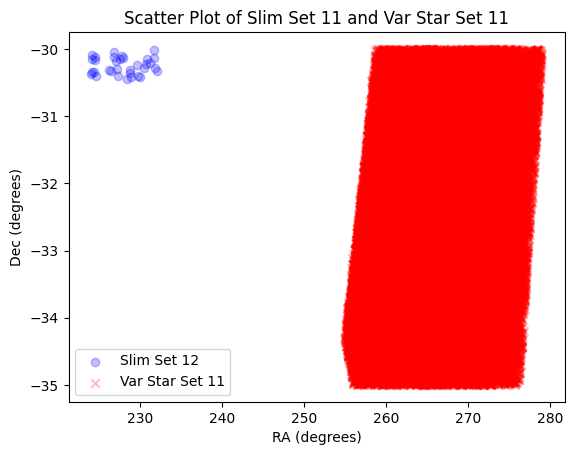

In [28]:
#should check this cell before comparing. may also give a general range to disregard to make the process faster
set_num = 13

# scatter plot for the 'slim_set{set_num}' dataframe
slim_coords = slim_sets[f'slim_set{set_num}']['Coordinate']
slim_ra = slim_coords.apply(lambda coord: coord.ra.deg)
slim_dec = slim_coords.apply(lambda coord: coord.dec.deg)
plt.scatter(slim_ra, slim_dec, label=f'Slim Set {set_num}', marker='o', color='blue', alpha=0.25)

# scatter plot for the 'var_star_set{set_num}' dataframe
var_coords = var_star_sets[f'var_star_set{set_num}']['Coordinate']
var_ra = var_coords.apply(lambda coord: coord.ra.deg)
var_dec = var_coords.apply(lambda coord: coord.dec.deg)
plt.scatter(var_ra, var_dec, label=f'Var Star Set {set_num}', marker='x', color='red', alpha=0.25)

# labels and title
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.title(f'Scatter Plot of Slim Set {set_num} and Var Star Set {set_num}')

# legend
plt.legend()

# plot
plt.show()
